In [ ]:
!pip install langchain langgraph langchain-groq langchain-huggingface langchain-chroma arxiv chromadb sentence-transformers pymupdf langchain-community

In [2]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
from langchain_community.document_loaders import ArxivLoader
from langchain_community.tools import ArxivQueryRun

loader = ArxivLoader(
    query="Retrieval Augmented Generation human feedback",
    max_results=3
)
docs = loader.load()

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(docs)

In [7]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [8]:
from langchain.chains import RetrievalQA

rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

In [38]:
from typing import Annotated, Dict, Any

class AgentState(Dict[str, Any]):
    query: str
    retrieved_docs: list
    initial_answer: str
    confidence_score: float
    human_feedback: str
    final_response: str
    requires_human_input: bool
    human_approved: bool

In [39]:
def get_confidence_score(query: str, answer: str, retrieved_docs: list) -> float:
    """Improved confidence scoring with multiple factors"""
    score = 0.5  # Base score

    # Check answer quality indicators
    if len(answer) < 100:
        score -= 0.3
    elif len(answer) > 500:
        score += 0.2

    # Check for uncertainty phrases
    uncertainty_phrases = [
        "i don't know", "unclear", "uncertain", "not sure",
        "i'm not a", "disclaimer", "consult", "professional advice"
    ]
    if any(phrase in answer.lower() for phrase in uncertainty_phrases):
        score -= 0.4

    # Check retrieval quality
    if len(retrieved_docs) < 2:
        score -= 0.2

    # Check for generic/templated responses
    if "I'm sorry, but I don't have information" in answer:
        score = 0.2

    return max(0.1, min(0.9, score))

In [40]:
def check_if_needs_human_input(state: AgentState) -> AgentState:
    """Logic for determining human input requirements"""
    confidence = state.get("confidence_score", 0.5)
    query_lower = state["query"].lower()
    answer_lower = state["initial_answer"].lower()

    # Define sensitive categories
    medical_keywords = ["treat", "broken bone", "injury", "medical", "health", "symptoms", "diagnosis"]
    financial_keywords = ["invest", "cryptocurrency", "financial", "money", "trading", "stock"]
    legal_keywords = ["legal", "lawsuit", "court", "lawyer", "attorney"]
    safety_keywords = ["dangerous", "toxic", "emergency", "safety"]

    # Check sensitive topics
    is_medical = any(keyword in query_lower for keyword in medical_keywords)
    is_financial = any(keyword in query_lower for keyword in financial_keywords)
    is_legal = any(keyword in query_lower for keyword in legal_keywords)
    is_safety = any(keyword in query_lower for keyword in safety_keywords)

    # Check for disclaimers in answer (indicates AI uncertainty)
    has_disclaimer = any(phrase in answer_lower for phrase in [
        "disclaimer", "not a", "consult", "professional advice", "seek qualified"
    ])

    # Determine if human input is needed
    needs_input = (
        confidence < 0.7 or
        is_medical or
        is_financial or
        is_legal or
        is_safety or
        has_disclaimer or
        len(state.get("initial_answer", "")) < 50
    )

    state["requires_human_input"] = needs_input

    if needs_input:
        reasons = []
        if confidence < 0.7:
            reasons.append(f"Low confidence ({confidence:.2f})")
        if is_medical:
            reasons.append("Medical topic")
        if is_financial:
            reasons.append("Financial topic")
        if is_legal:
            reasons.append("Legal topic")
        if has_disclaimer:
            reasons.append("Contains disclaimer")

        print(f"\n🚨 HUMAN INPUT REQUIRED 🚨")
        print(f"Query: {state['query']}")
        print(f"Reasons: {', '.join(reasons)}")
        print(f"Answer preview: {state['initial_answer'][:200]}...")
    else:
        print(f"✅ Auto-approval criteria met (confidence: {confidence:.2f})")

    return state

In [41]:
def retrieve_and_generate(state: AgentState) -> AgentState:
    """Initial retrieval and generation step"""
    query = state["query"]

    result = rag_chain.invoke({"query": query})

    state["retrieved_docs"] = result["source_documents"]
    state["initial_answer"] = result["result"]
    state["confidence_score"] = get_confidence_score(query, result["result"], state["retrieved_docs"])

    print(f"📚 Retrieved {len(result['source_documents'])} documents")
    print(f"🤖 Generated initial answer (confidence: {state['confidence_score']:.2f})")

    return state

In [42]:
def wait_for_human_approval(state: AgentState) -> AgentState:
    """Enhanced human approval with multiple interaction methods"""
    print(f"\n⏳ HUMAN REVIEW REQUIRED")
    print(f"Query: {state['query']}")
    print(f"Confidence: {state['confidence_score']:.2f}")
    print(f"Proposed Answer:\n{state['initial_answer']}")

    # Show retrieved sources for context
    if "retrieved_docs" in state and state["retrieved_docs"]:
        print(f"\n📚 Sources ({len(state['retrieved_docs'])} documents):")
        for i, doc in enumerate(state["retrieved_docs"][:2]):  # Show first 2
            title = doc.metadata.get('Title', 'Unknown')
            print(f"  {i+1}. {title[:60]}...")

    print(f"\n" + "="*60)
    print("HUMAN OPTIONS:")
    print("1. 'approve' - Accept the answer as-is")
    print("2. 'reject' - Reject and request new research")
    print("3. 'edit: [correction]' - Approve with modifications")
    print("4. 'clarify: [question]' - Ask for clarification before deciding")
    print("5. 'escalate' - Send to expert human reviewer")
    print("="*60)

    # Different simulation modes for testing
    test_scenarios = {
        "medical": "reject",  # Medical should be rejected by AI
        "financial": "edit: Please add that this is not personalized financial advice and individual circumstances vary greatly.",
        "technical": "approve",
        "unclear": "clarify: Can you provide more specific examples?",
        "sensitive": "escalate"
    }

    # Determine scenario type
    query_lower = state["query"].lower()
    if any(word in query_lower for word in ["treat", "broken", "medical"]):
        scenario = "medical"
    elif any(word in query_lower for word in ["invest", "cryptocurrency", "financial"]):
        scenario = "financial"
    elif any(word in query_lower for word in ["rag", "technical", "generation"]):
        scenario = "technical"
    elif "don't have information" in state["initial_answer"]:
        scenario = "unclear"
    else:
        scenario = "sensitive"

    human_input = test_scenarios.get(scenario, "approve")
    print(f"\n🎭 Simulated human decision ({scenario} scenario): {human_input}")

    state["human_feedback"] = human_input

    # Process different types of feedback
    if human_input.lower() == "approve":
        state["human_approved"] = True
        state["final_response"] = state["initial_answer"]
        print("✅ Human approved the response")

    elif human_input.lower() == "reject":
        state["human_approved"] = False
        state["final_response"] = "❌ Response rejected by human reviewer. This query requires expert consultation or additional research before providing an answer."
        print("❌ Human rejected the response")

    elif human_input.lower().startswith("edit:"):
        state["human_approved"] = True
        correction = human_input[5:].strip()
        state["final_response"] = f"{state['initial_answer']}\n\n✏️ **Human Amendment:** {correction}"
        print("✏️ Human approved with edits")

    elif human_input.lower().startswith("clarify:"):
        state["human_approved"] = False
        clarification_request = human_input[8:].strip()
        state["final_response"] = f"❓ **Clarification Needed:** {clarification_request}\n\nOriginal answer held pending clarification: {state['initial_answer'][:100]}..."
        print("❓ Human requested clarification")

    elif human_input.lower() == "escalate":
        state["human_approved"] = False
        state["final_response"] = "🔺 **Escalated to Expert Review:** This query has been forwarded to a subject matter expert for specialized review."
        print("🔺 Escalated to expert reviewer")

    return state

In [43]:
def auto_approve(state: AgentState) -> AgentState:
    """Auto-approve high-confidence answers"""
    state["human_approved"] = True
    state["final_response"] = state["initial_answer"]
    state["human_feedback"] = "Auto-approved (high confidence)"

    print("✅ Auto-approved due to high confidence")
    return state

In [44]:
def route_decision(state: AgentState) -> str:
    """Enhanced routing with logging"""
    if state["requires_human_input"]:
        print("🔀 Routing to human approval")
        return "human_approval"
    else:
        print("🔀 Routing to auto-approval")
        return "auto_approve"

In [45]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieve_generate", retrieve_and_generate)
workflow.add_node("check_human_need", check_if_needs_human_input)
workflow.add_node("human_approval", wait_for_human_approval)
workflow.add_node("auto_approve", auto_approve)

# Add edges
workflow.set_entry_point("retrieve_generate")
workflow.add_edge("retrieve_generate", "check_human_need")

workflow.add_conditional_edges(
    "check_human_need",
    route_decision,
    {
        "human_approval": "human_approval",
        "auto_approve": "auto_approve"
    }
)

workflow.set_finish_point("human_approval")
workflow.set_finish_point("auto_approve")

# Compile with memory for checkpointing
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

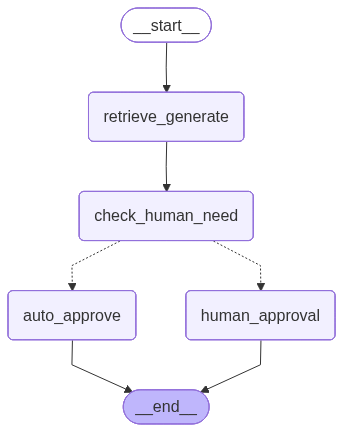

In [46]:
app

In [47]:
from langchain_core.messages import HumanMessage, AIMessage
import uuid

def run_query(query: str, thread_id: str = None):
    """Run a query through the human-in-the-loop RAG system"""
    if thread_id is None:
        thread_id = str(uuid.uuid4())

    config = {"configurable": {"thread_id": thread_id}}

    print(f"\n{'='*60}")
    print(f"🔍 QUERY: {query}")
    print(f"📋 Thread ID: {thread_id}")
    print(f"{'='*60}")

    # Initial state
    initial_state = AgentState(query=query)

    # Run the workflow
    result = app.invoke(initial_state, config)

    print(f"\n📊 FINAL RESULT:")
    print(f"Response: {result['final_response']}")
    print(f"Human Approved: {result['human_approved']}")
    print(f"Confidence Score: {result['confidence_score']:.2f}")
    print(f"Human Feedback: {result['human_feedback']}")

    return result, thread_id

# Test with different types of queries
test_queries = [
    "What is Retrieval Augmented Generation?",
    "How do I treat a broken bone?",  # Medical - should trigger human review
    "What are the latest RAG techniques in 2024?",
    "Should I invest in cryptocurrency?"  # Financial - should trigger human review
]

results = []
for query in test_queries:
    result, thread_id = run_query(query)
    results.append((query, result, thread_id))
    print("\n" + "="*80 + "\n")


🔍 QUERY: What is Retrieval Augmented Generation?
📋 Thread ID: ec59b18c-bf7c-4209-92e4-0c54935f0187
📚 Retrieved 3 documents
🤖 Generated initial answer (confidence: 0.70)
✅ Auto-approval criteria met (confidence: 0.70)
🔀 Routing to auto-approval
✅ Auto-approved due to high confidence

📊 FINAL RESULT:
Response: **Retrieval‑Augmented Generation (RAG)** is a technique that couples a large language model’s generative abilities with an external “retriever” that fetches relevant information from a knowledge source (e.g., documents, code snippets, web pages).  

1. **Retriever** – given a user prompt, it searches a database or the web and returns the most relevant pieces of text (or other content).  
2. **Generator** – the LLM receives both the original prompt **and** the retrieved material, and then synthesizes its response using that grounded context.

The goal of RAG is to anchor the model’s output in factual data, thereby reducing hallucinations and making the generated content more reliab

In [48]:
def demonstrate_checkpointing():
    """Show how to pause and resume execution using checkpoints"""

    print("🔄 DEMONSTRATING CHECKPOINTING CAPABILITIES")
    print("="*50)

    # Create a thread
    thread_id = "demo-checkpoint-thread"
    config = {"configurable": {"thread_id": thread_id}}

    # Get current state (if any)
    try:
        current_state = app.get_state(config)
        print(f"Current state: {current_state}")
    except:
        print("No existing state found")

    # Show state history for a completed run
    if results:
        _, completed_result, completed_thread = results[0]
        completed_config = {"configurable": {"thread_id": completed_thread}}

        print(f"\nState history for completed thread {completed_thread}:")
        try:
            history = app.get_state_history(completed_config)
            for i, state in enumerate(history):
                print(f"Step {i}: {list(state.values.keys()) if hasattr(state, 'values') else 'Unknown'}")
        except Exception as e:
            print(f"Could not retrieve history: {e}")

demonstrate_checkpointing()

🔄 DEMONSTRATING CHECKPOINTING CAPABILITIES
Current state: StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'demo-checkpoint-thread'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

State history for completed thread ec59b18c-bf7c-4209-92e4-0c54935f0187:
Step 0: ['query', 'retrieved_docs', 'initial_answer', 'confidence_score', 'human_feedback', 'final_response', 'requires_human_input', 'human_approved']
Step 1: ['query', 'retrieved_docs', 'initial_answer', 'confidence_score', 'requires_human_input']
Step 2: ['query', 'retrieved_docs', 'initial_answer', 'confidence_score']
Step 3: ['query']
Step 4: []


In [49]:
# Show retrieved documents for transparency
def show_retrieved_sources(result):
    """Display source documents for transparency"""
    if "retrieved_docs" in result:
        print(f"\n📚 RETRIEVED SOURCES:")
        for i, doc in enumerate(result["retrieved_docs"]):
            print(f"\nSource {i+1}:")
            print(f"Title: {doc.metadata.get('Title', 'Unknown')}")
            print(f"Authors: {doc.metadata.get('Authors', 'Unknown')}")
            print(f"Content preview: {doc.page_content[:200]}...")

# Demonstrate source transparency
if results:
    print("🔍 SHOWING SOURCE TRANSPARENCY")
    show_retrieved_sources(results[0][1])

print(f"\n🎉 Human-in-the-Loop RAG Demo Complete!")
print(f"Key Features Demonstrated:")
print(f"✅ Automatic confidence scoring")
print(f"✅ Human approval for low-confidence/sensitive queries")
print(f"✅ Checkpointing and state persistence")
print(f"✅ Conditional routing based on requirements")
print(f"✅ Source document transparency")
print(f"✅ Multiple interaction patterns (approve/reject/edit)")

🔍 SHOWING SOURCE TRANSPARENCY

📚 RETRIEVED SOURCES:

Source 1:
Title: Can Language Models Critique Themselves? Investigating Self-Feedback for Retrieval Augmented Generation at BioASQ 2025
Authors: Samy Ateia, Udo Kruschwitz
Content preview: any self-feedback loop.
2.3. Retrieval Augmented Generation (RAG)
Retrieval Augmented Generation (RAG) combines the generative capabilities of LLMs with information
retrieved from external knowledge s...

Source 2:
Title: Can Language Models Critique Themselves? Investigating Self-Feedback for Retrieval Augmented Generation at BioASQ 2025
Authors: Samy Ateia, Udo Kruschwitz
Content preview: Language Model Post-Training, 2025. URL: https://arxiv.org/abs/2411.15124. arXiv:2411.15124.
[20] P. Lewis, E. Perez, A. Piktus, F. Petroni, V. Karpukhin, N. Goyal, H. Küttler, M. Lewis,
W. tau Yih, T...

Source 3:
Title: Improving Retrieval-Augmented Code Comment Generation by Retrieving for Generation
Authors: Hanzhen Lu, Zhongxin Liu
Content preview: The gene